# Trying Other Metrics

In this notebook I'll be running some further metrics past the ImageNet-1k sanity checks to see if we can have any good candidates to pick up now that PARC and TDA have fallen off.

The metrics I'll be trying out are:
1. LogME
2. H_alpha - score
3. NCE
4. LEEP
5. NLEEP?

With the process of loading several models pretrained on ImageNet and computing the metric scores (with the recommended hyperparameters) to assess how well they do. Most of these have implementations available so I'll be using those to start off, before adapting them to our framework if they make it past the sanity checks.

## Loading Dataset and Models

First lets load the dataset and the models, then extract the features.

In [2]:
import yaml
from datasets import IterableDataset, load_dataset
from transformers import AutoImageProcessor, AutoModelForImageClassification

In [3]:
dataset = load_dataset("imagenet-1k", split="validation", streaming=True, token=True)

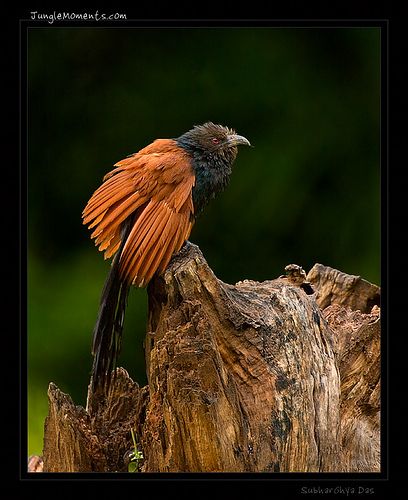

In [4]:
next(iter(dataset))["image"]

In [5]:
# Image preprocessing fnc


def preprocess(examples, processor):
    examples["pixel_values"] = [
        processor(image.convert("RGB"))["pixel_values"][0]
        for image in examples["image"]
    ]
    return examples

In [6]:
# Extract features fnc


def extract_features(model_name: str, n_examples: int, dataset: IterableDataset):
    # load model and processor
    model_fn = AutoModelForImageClassification.from_pretrained(model_name, num_labels=0)
    processor = AutoImageProcessor.from_pretrained(model_name)

    # preprocess data:
    fn_kwargs = {"processor": processor}
    imgs = dataset.map(
        preprocess,
        remove_columns="image",
        batched=True,
        batch_size=1,
        fn_kwargs=fn_kwargs,
    )
    imgs = imgs.with_format("torch")

    # fxtract features and labels:
    feats = []
    for idx, itm in enumerate(imgs):
        feats.append(
            (
                model_fn(itm["pixel_values"][None, :, :, :]).logits.detach().numpy(),
                itm["label"].detach().numpy(),
            )
        )
        if idx == n_examples - 1:
            break
    return feats

In [7]:
# extract classes


def extract_classes(model_name: str, n_examples: int, dataset: IterableDataset):
    # load model and processor
    model_fn = AutoModelForImageClassification.from_pretrained(model_name)
    processor = AutoImageProcessor.from_pretrained(model_name)

    # preprocess data:
    fn_kwargs = {"processor": processor}
    imgs = dataset.map(
        preprocess,
        remove_columns="image",
        batched=True,
        batch_size=1,
        fn_kwargs=fn_kwargs,
    )
    imgs = imgs.with_format("torch")

    # fxtract features and labels:
    feats = []
    for idx, itm in enumerate(imgs):
        feats.append(
            (
                model_fn(itm["pixel_values"][None, :, :, :]).logits.argmax(-1).item(),
                itm["label"].detach().numpy(),
            )
        )
        if idx == n_examples - 1:
            break
    return feats

In [8]:
with open("../configs/scores_imagenet1k.yaml", "r") as f:
    actuals = yaml.safe_load(f)

In [9]:
actuals

{'facebook/deit-tiny-patch16-224': 72.2,
 'facebook/deit-small-patch16-224': 79.9,
 'facebook/deit-base-patch16-224': 81.8,
 'google/vit-base-patch16-384': 85.49,
 'microsoft/cvt-13': 81.6}

In [10]:
feat_eg = extract_features(list(actuals.keys())[0], 10, dataset)

Some weights of the model checkpoint at facebook/deit-tiny-patch16-224 were not used when initializing ViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
feat_eg[0][0].shape

(1, 192)

In [12]:
# plotting function
import matplotlib.pyplot as plt


def plotter(results: dict, title):
    plt.scatter(list(actuals.values()), list(results.values()))
    plt.suptitle(title)
    plt.show()

## Loading the other metrics

Computing the metrics listed above stated above.

### LogME

In [13]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

from LogME.LogME import LogME

In [56]:
# load logme object
logme = LogME(regression=False)

In [57]:
# format features and labels
features = np.concatenate([feats[0] for feats in feat_eg], axis=0)
labels = np.concatenate([[feats[1]] for feats in feat_eg], axis=0)

In [58]:
labels

array([ 91, 171, 980, 218,  19, 658, 549, 808, 305, 416])

In [41]:
# one hot encode labels
labels = OneHotEncoder(sparse_output=False).fit_transform(labels.reshape(-1, 1))

In [43]:
labels.shape

(10, 10)

In [59]:
# get logme score
logme.fit(features, labels)

127.93697834812384

In [60]:
# run pipeline for all models:
results = {}
for model in actuals.keys():
    feats = extract_features(model, 500, dataset)
    features = np.concatenate([feat[0] for feat in feats], axis=0)
    print(f"features shape for {model}: {features.shape}")
    labels = np.concatenate([[feat[1]] for feat in feats], axis=0)
    # labels = OneHotEncoder(sparse_output=False).fit_transform(labels.reshape(-1, 1))
    print(f"labels shape for {model}: {labels.shape}")
    results[model] = logme.fit(features, labels)
    print(f"results for {model} is {results[model]}")

Some weights of the model checkpoint at facebook/deit-tiny-patch16-224 were not used when initializing ViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


features shape for facebook/deit-tiny-patch16-224: (500, 192)
labels shape for facebook/deit-tiny-patch16-224: (500,)


/Users/edable-heath/Documents/ARC-LoCoMoSeT/src/LogME/LogME.py:172: UserWarning: re-fitting for new data. old parameters cleared.
  warnings.warn('re-fitting for new data. old parameters cleared.')


results for facebook/deit-tiny-patch16-224 is 4.487818163552645


Some weights of the model checkpoint at facebook/deit-small-patch16-224 were not used when initializing ViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


features shape for facebook/deit-small-patch16-224: (500, 384)
labels shape for facebook/deit-small-patch16-224: (500,)
results for facebook/deit-small-patch16-224 is 4.130619863810876


Some weights of the model checkpoint at facebook/deit-base-patch16-224 were not used when initializing ViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


features shape for facebook/deit-base-patch16-224: (500, 768)
labels shape for facebook/deit-base-patch16-224: (500,)
results for facebook/deit-base-patch16-224 is 8.19850666511815


Some weights of the model checkpoint at google/vit-base-patch16-384 were not used when initializing ViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


features shape for google/vit-base-patch16-384: (500, 768)
labels shape for google/vit-base-patch16-384: (500,)
results for google/vit-base-patch16-384 is 7.930920198852002


Some weights of the model checkpoint at microsoft/cvt-13 were not used when initializing CvtForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing CvtForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CvtForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


features shape for microsoft/cvt-13: (500, 384)
labels shape for microsoft/cvt-13: (500,)
results for microsoft/cvt-13 is 4.3961817212914305


In [64]:
results

{'facebook/deit-tiny-patch16-224': 4.487818163552645,
 'facebook/deit-small-patch16-224': 4.130619863810876,
 'facebook/deit-base-patch16-224': 8.19850666511815,
 'google/vit-base-patch16-384': 7.930920198852002,
 'microsoft/cvt-13': 4.3961817212914305}

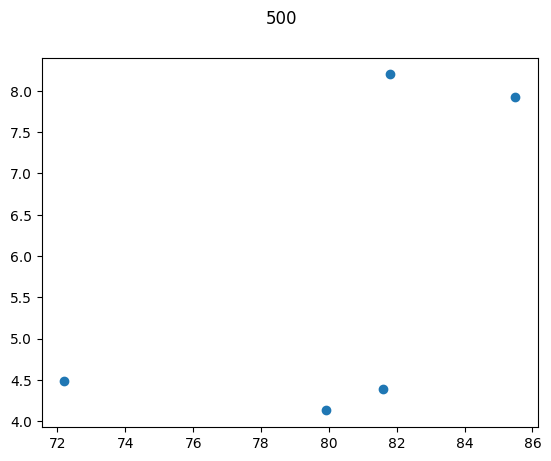

In [66]:
# plot results
plotter(results, str(500))

In [68]:
# LogME pipleline for experiments:


def logeme_pipeline(n_examples):
    results = {}
    for model in actuals.keys():
        feats = extract_features(model, n_examples, dataset)
        features = np.concatenate([feat[0] for feat in feats], axis=0)
        print(f"features shape for {model}: {features.shape}")
        labels = np.concatenate([[feat[1]] for feat in feats], axis=0)
        # labels = OneHotEncoder(sparse_output=False).fit_transform(labels.reshape(-1, 1))
        print(f"labels shape for {model}: {labels.shape}")
        results[model] = logme.fit(features, labels)
        print(f"results for {model} is {results[model]}")
    print(results)
    plotter(results, str(n_examples))
    return results

Some weights of the model checkpoint at facebook/deit-tiny-patch16-224 were not used when initializing ViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


features shape for facebook/deit-tiny-patch16-224: (250, 192)
labels shape for facebook/deit-tiny-patch16-224: (250,)


/Users/edable-heath/Documents/ARC-LoCoMoSeT/src/LogME/LogME.py:172: UserWarning: re-fitting for new data. old parameters cleared.
  warnings.warn('re-fitting for new data. old parameters cleared.')


results for facebook/deit-tiny-patch16-224 is 4.380811913642204


Some weights of the model checkpoint at facebook/deit-small-patch16-224 were not used when initializing ViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


features shape for facebook/deit-small-patch16-224: (250, 384)
labels shape for facebook/deit-small-patch16-224: (250,)
results for facebook/deit-small-patch16-224 is 8.509326640664996


Some weights of the model checkpoint at facebook/deit-base-patch16-224 were not used when initializing ViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


features shape for facebook/deit-base-patch16-224: (250, 768)
labels shape for facebook/deit-base-patch16-224: (250,)
results for facebook/deit-base-patch16-224 is 20.49476298345611


Some weights of the model checkpoint at google/vit-base-patch16-384 were not used when initializing ViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


features shape for google/vit-base-patch16-384: (250, 768)
labels shape for google/vit-base-patch16-384: (250,)
results for google/vit-base-patch16-384 is 20.19408444379799


Some weights of the model checkpoint at microsoft/cvt-13 were not used when initializing CvtForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing CvtForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CvtForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


features shape for microsoft/cvt-13: (250, 384)
labels shape for microsoft/cvt-13: (250,)
results for microsoft/cvt-13 is 8.850554787699032
{'facebook/deit-tiny-patch16-224': 4.380811913642204, 'facebook/deit-small-patch16-224': 8.509326640664996, 'facebook/deit-base-patch16-224': 20.49476298345611, 'google/vit-base-patch16-384': 20.19408444379799, 'microsoft/cvt-13': 8.850554787699032}


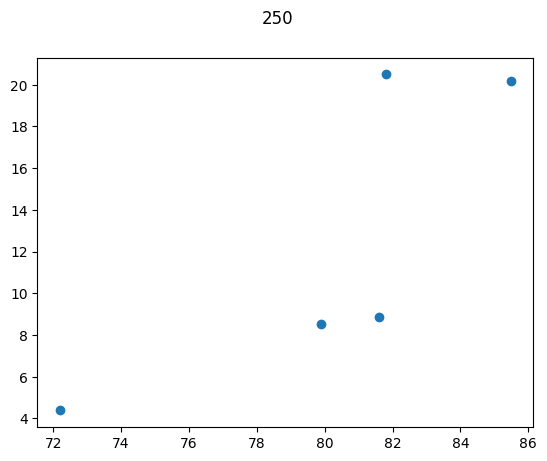

Some weights of the model checkpoint at facebook/deit-tiny-patch16-224 were not used when initializing ViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


features shape for facebook/deit-tiny-patch16-224: (500, 192)
labels shape for facebook/deit-tiny-patch16-224: (500,)
results for facebook/deit-tiny-patch16-224 is 4.487818163552645


Some weights of the model checkpoint at facebook/deit-small-patch16-224 were not used when initializing ViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


features shape for facebook/deit-small-patch16-224: (500, 384)
labels shape for facebook/deit-small-patch16-224: (500,)
results for facebook/deit-small-patch16-224 is 4.130619863810876


Some weights of the model checkpoint at facebook/deit-base-patch16-224 were not used when initializing ViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


features shape for facebook/deit-base-patch16-224: (500, 768)
labels shape for facebook/deit-base-patch16-224: (500,)
results for facebook/deit-base-patch16-224 is 8.19850666511815


Some weights of the model checkpoint at google/vit-base-patch16-384 were not used when initializing ViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


features shape for google/vit-base-patch16-384: (500, 768)
labels shape for google/vit-base-patch16-384: (500,)
results for google/vit-base-patch16-384 is 7.930920198852002


Some weights of the model checkpoint at microsoft/cvt-13 were not used when initializing CvtForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing CvtForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CvtForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


features shape for microsoft/cvt-13: (500, 384)
labels shape for microsoft/cvt-13: (500,)
results for microsoft/cvt-13 is 4.3961817212914305
{'facebook/deit-tiny-patch16-224': 4.487818163552645, 'facebook/deit-small-patch16-224': 4.130619863810876, 'facebook/deit-base-patch16-224': 8.19850666511815, 'google/vit-base-patch16-384': 7.930920198852002, 'microsoft/cvt-13': 4.3961817212914305}


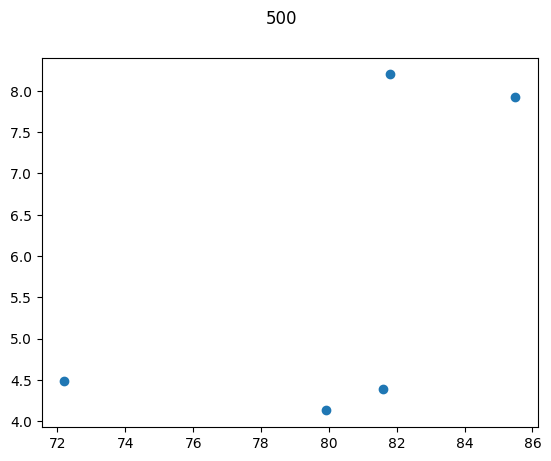

Some weights of the model checkpoint at facebook/deit-tiny-patch16-224 were not used when initializing ViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


features shape for facebook/deit-tiny-patch16-224: (1000, 192)
labels shape for facebook/deit-tiny-patch16-224: (1000,)
results for facebook/deit-tiny-patch16-224 is 3.8484642621428056


Some weights of the model checkpoint at facebook/deit-small-patch16-224 were not used when initializing ViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


features shape for facebook/deit-small-patch16-224: (1000, 384)
labels shape for facebook/deit-small-patch16-224: (1000,)
results for facebook/deit-small-patch16-224 is 3.6619533803170805


Some weights of the model checkpoint at facebook/deit-base-patch16-224 were not used when initializing ViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


features shape for facebook/deit-base-patch16-224: (1000, 768)
labels shape for facebook/deit-base-patch16-224: (1000,)
results for facebook/deit-base-patch16-224 is 3.4868303709048223


Some weights of the model checkpoint at google/vit-base-patch16-384 were not used when initializing ViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


features shape for google/vit-base-patch16-384: (1000, 768)
labels shape for google/vit-base-patch16-384: (1000,)
results for google/vit-base-patch16-384 is 3.3120234493907637


Some weights of the model checkpoint at microsoft/cvt-13 were not used when initializing CvtForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing CvtForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CvtForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


features shape for microsoft/cvt-13: (1000, 384)
labels shape for microsoft/cvt-13: (1000,)
results for microsoft/cvt-13 is 3.7505414238916437
{'facebook/deit-tiny-patch16-224': 3.8484642621428056, 'facebook/deit-small-patch16-224': 3.6619533803170805, 'facebook/deit-base-patch16-224': 3.4868303709048223, 'google/vit-base-patch16-384': 3.3120234493907637, 'microsoft/cvt-13': 3.7505414238916437}


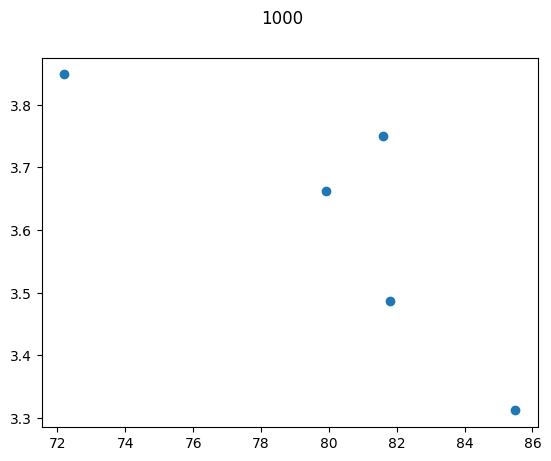

Some weights of the model checkpoint at facebook/deit-tiny-patch16-224 were not used when initializing ViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


features shape for facebook/deit-tiny-patch16-224: (2000, 192)
labels shape for facebook/deit-tiny-patch16-224: (2000,)
results for facebook/deit-tiny-patch16-224 is 2.8089713375295515


Some weights of the model checkpoint at facebook/deit-small-patch16-224 were not used when initializing ViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


features shape for facebook/deit-small-patch16-224: (2000, 384)
labels shape for facebook/deit-small-patch16-224: (2000,)
results for facebook/deit-small-patch16-224 is 2.772891458066837


Some weights of the model checkpoint at facebook/deit-base-patch16-224 were not used when initializing ViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


features shape for facebook/deit-base-patch16-224: (2000, 768)
labels shape for facebook/deit-base-patch16-224: (2000,)
results for facebook/deit-base-patch16-224 is 2.7233904583102357


Some weights of the model checkpoint at google/vit-base-patch16-384 were not used when initializing ViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


features shape for google/vit-base-patch16-384: (2000, 768)
labels shape for google/vit-base-patch16-384: (2000,)
results for google/vit-base-patch16-384 is 2.6995674804769654


Some weights of the model checkpoint at microsoft/cvt-13 were not used when initializing CvtForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing CvtForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CvtForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


features shape for microsoft/cvt-13: (2000, 384)
labels shape for microsoft/cvt-13: (2000,)
results for microsoft/cvt-13 is 2.794180905463125
{'facebook/deit-tiny-patch16-224': 2.8089713375295515, 'facebook/deit-small-patch16-224': 2.772891458066837, 'facebook/deit-base-patch16-224': 2.7233904583102357, 'google/vit-base-patch16-384': 2.6995674804769654, 'microsoft/cvt-13': 2.794180905463125}


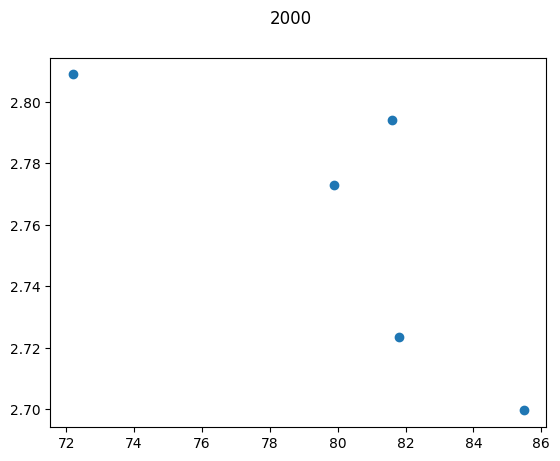

Some weights of the model checkpoint at facebook/deit-tiny-patch16-224 were not used when initializing ViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


features shape for facebook/deit-tiny-patch16-224: (4000, 192)
labels shape for facebook/deit-tiny-patch16-224: (4000,)
results for facebook/deit-tiny-patch16-224 is 2.1813979371901344


Some weights of the model checkpoint at facebook/deit-small-patch16-224 were not used when initializing ViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


features shape for facebook/deit-small-patch16-224: (4000, 384)
labels shape for facebook/deit-small-patch16-224: (4000,)
results for facebook/deit-small-patch16-224 is 2.191401724635157


Some weights of the model checkpoint at facebook/deit-base-patch16-224 were not used when initializing ViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


features shape for facebook/deit-base-patch16-224: (4000, 768)
labels shape for facebook/deit-base-patch16-224: (4000,)
results for facebook/deit-base-patch16-224 is 2.204888991825064


Some weights of the model checkpoint at google/vit-base-patch16-384 were not used when initializing ViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


features shape for google/vit-base-patch16-384: (4000, 768)
labels shape for google/vit-base-patch16-384: (4000,)
results for google/vit-base-patch16-384 is 2.220612899110816


Some weights of the model checkpoint at microsoft/cvt-13 were not used when initializing CvtForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing CvtForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CvtForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


features shape for microsoft/cvt-13: (4000, 384)
labels shape for microsoft/cvt-13: (4000,)
results for microsoft/cvt-13 is 2.1998226126106237
{'facebook/deit-tiny-patch16-224': 2.1813979371901344, 'facebook/deit-small-patch16-224': 2.191401724635157, 'facebook/deit-base-patch16-224': 2.204888991825064, 'google/vit-base-patch16-384': 2.220612899110816, 'microsoft/cvt-13': 2.1998226126106237}


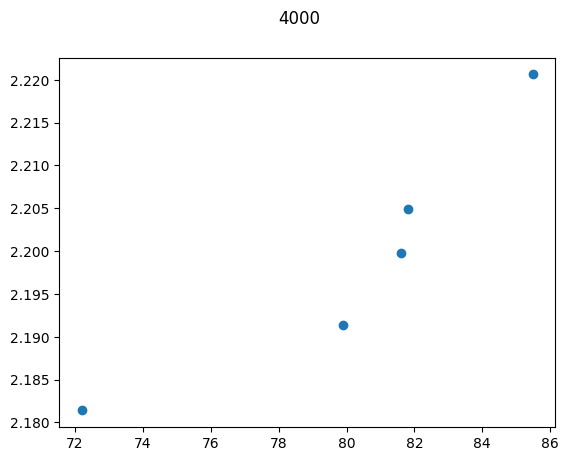

In [70]:
test_sets = [250, 500, 1000, 2000, 4000]
results_list = []
for t in test_sets:
    results_list.append(logeme_pipeline(t))

It looks like LogME starts to give the right ranking after enough datapoints considered within the probe set. In the literature it appears that they consider the entire dataset, but at what size of probeset does this this start to level off? I would have thought this would be related to the number of classes, so worth trying this we different datasets to see if the value changes. 

Further to this it is worth confirming that this isn't just a fluke and that the LogME value doesn't vary hugely with different probe sets.

In [92]:
# Experiment with one model to see how the value of LogMe changes with a growing probeset.
random_state = [42, 43, 44]
probe_set_sizes = [
    250,
    500,
    1000,
    1500,
    2000,
    2500,
    3000,
    3500,
    4000,
    4500,
    5000,
    5500,
    6000,
]
results = {state: [] for state in random_state}
model = "facebook/deit-tiny-patch16-224"

comp_feature = {}
for state in random_state:
    sub_dataset = dataset.shuffle(seed=state)
    comp_feature[state] = extract_features(model, 6000, sub_dataset)

for size in probe_set_sizes:
    for state in random_state:
        features = np.concatenate(
            [feat[0] for feat in comp_feature[state][:size]], axis=0
        )
        labels = np.concatenate(
            [[feat[1]] for feat in comp_feature[state][:size]], axis=0
        )
        logme_value = logme.fit(features, labels)
        results[state].append(logme_value)
        print(f"results for {model} at size {size} is {logme_value}")

Some weights of the model checkpoint at facebook/deit-tiny-patch16-224 were not used when initializing ViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at facebook/deit-tiny-patch16-224 were not used when initializing ViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a

results for facebook/deit-tiny-patch16-224 at size 10 is 127.99705393184225
results for facebook/deit-tiny-patch16-224 at size 10 is 127.91000946191602
results for facebook/deit-tiny-patch16-224 at size 10 is 127.93082078523412
results for facebook/deit-tiny-patch16-224 at size 250 is 4.371117054839047
results for facebook/deit-tiny-patch16-224 at size 250 is 4.377013830473956
results for facebook/deit-tiny-patch16-224 at size 250 is 4.394943012030522
results for facebook/deit-tiny-patch16-224 at size 500 is 4.5271652146487575
results for facebook/deit-tiny-patch16-224 at size 500 is 4.4759184898988265
results for facebook/deit-tiny-patch16-224 at size 500 is 4.478970145997685
results for facebook/deit-tiny-patch16-224 at size 1000 is 3.812128642323013
results for facebook/deit-tiny-patch16-224 at size 1000 is 3.8402085477540617
results for facebook/deit-tiny-patch16-224 at size 1000 is 3.8287913123728323
results for facebook/deit-tiny-patch16-224 at size 1500 is 3.2016966353462384
res

In [102]:
probe_set_sizes = [
    250,
    500,
    1000,
    1500,
    2000,
    2500,
    3000,
    3500,
    4000,
    4500,
    5000,
    5500,
    6000,
]

In [106]:
results[42].insert(0, 4.371117054839047)
results[43].insert(0, 4.377013830473956)
results[44].insert(0, 4.394943012030522)

Text(0.5, 0.98, 'Probe set size vs LogME score for facebook/deit-tiny-patch16-224')

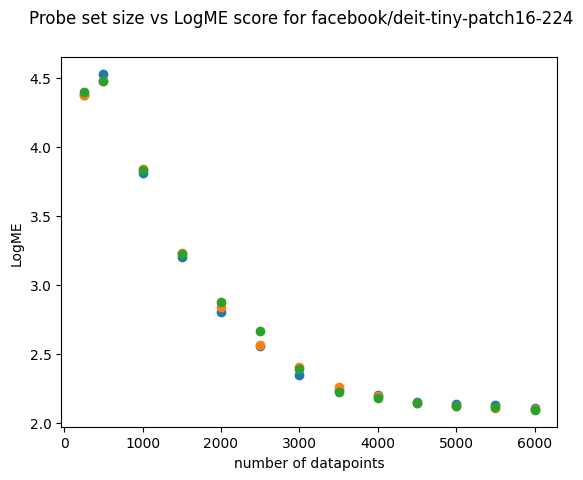

In [109]:
fig, ax = plt.subplots()
for state in random_state:
    ax.scatter(probe_set_sizes, results[state])
ax.set_xlabel("number of datapoints")
ax.set_ylabel("LogME")
fig.suptitle("Probe set size vs LogME score for facebook/deit-tiny-patch16-224")

Lets try this for the vit model as well:

In [110]:
# Experiment with one model to see how the value of LogMe changes with a growing probeset.
random_state = [42, 43, 44]
probe_set_sizes = [
    250,
    500,
    1000,
    1500,
    2000,
    2500,
    3000,
    3500,
    4000,
    4500,
    5000,
    5500,
    6000,
]
g_logme_results = {state: [] for state in random_state}
model = "google/vit-base-patch16-384"

comp_feature = {}
for state in random_state:
    sub_dataset = dataset.shuffle(seed=state)
    comp_feature[state] = extract_features(model, 6000, sub_dataset)

for size in probe_set_sizes:
    for state in random_state:
        features = np.concatenate(
            [feat[0] for feat in comp_feature[state][:size]], axis=0
        )
        labels = np.concatenate(
            [[feat[1]] for feat in comp_feature[state][:size]], axis=0
        )
        logme_value = logme.fit(features, labels)
        g_logme_results[state].append(logme_value)
        print(f"results for {model} at size {size} is {logme_value}")

Some weights of the model checkpoint at google/vit-base-patch16-384 were not used when initializing ViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at google/vit-base-patch16-384 were not used when initializing ViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertF

results for google/vit-base-patch16-384 at size 250 is 20.167920155790643
results for google/vit-base-patch16-384 at size 250 is 20.182487930677457
results for google/vit-base-patch16-384 at size 250 is 20.216589483861046
results for google/vit-base-patch16-384 at size 500 is 7.967888140720205
results for google/vit-base-patch16-384 at size 500 is 7.924461528822217
results for google/vit-base-patch16-384 at size 500 is 7.929926071090346
results for google/vit-base-patch16-384 at size 1000 is 3.288234384343531
results for google/vit-base-patch16-384 at size 1000 is 3.306859335342816
results for google/vit-base-patch16-384 at size 1000 is 3.2992500678222267
results for google/vit-base-patch16-384 at size 1500 is 2.954192257100502
results for google/vit-base-patch16-384 at size 1500 is 2.977094829731888
results for google/vit-base-patch16-384 at size 1500 is 2.973332234843653
results for google/vit-base-patch16-384 at size 2000 is 2.693887758482528
results for google/vit-base-patch16-384 

Text(0.5, 0.98, 'Probe set size vs LogME score for google/vit-base-patch16-384')

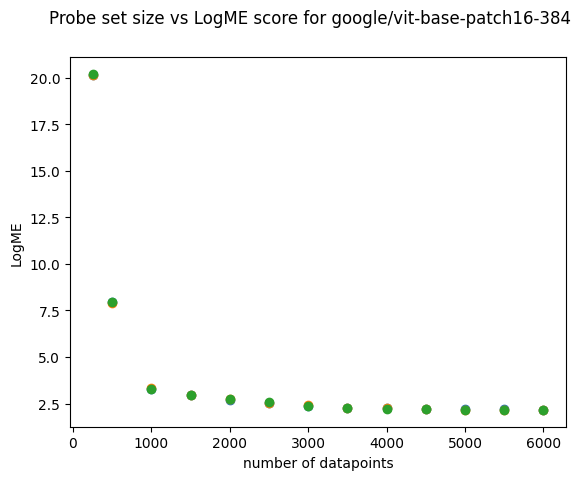

In [112]:
fig, ax = plt.subplots()
for state in random_state:
    ax.scatter(probe_set_sizes, g_logme_results[state])
ax.set_xlabel("number of datapoints")
ax.set_ylabel("LogME")
fig.suptitle("Probe set size vs LogME score for google/vit-base-patch16-384")

Text(0.5, 0.98, 'Probe set size vs LogME score for google/vit-base-patch16-384')

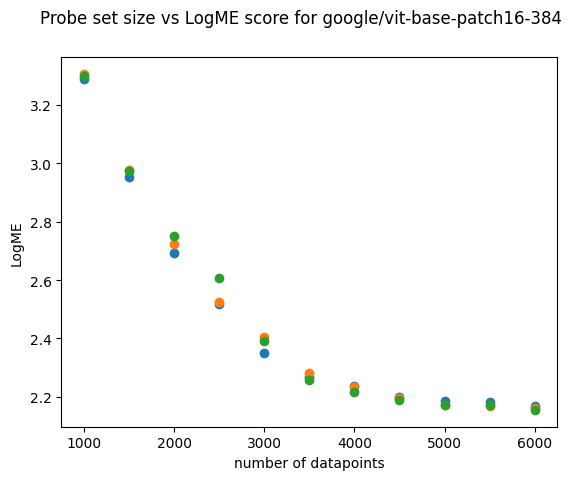

In [115]:
from copy import copy

fig, ax = plt.subplots()
g_logme_results_copy = copy(g_logme_results)
probe_set_sizes = [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000]
for state in random_state:
    g_logme_results_copy[state].pop(0)
for state in random_state:
    ax.scatter(probe_set_sizes, g_logme_results[state])
ax.set_xlabel("number of datapoints")
ax.set_ylabel("LogME")
fig.suptitle("Probe set size vs LogME score for google/vit-base-patch16-384")

### NCE

In [11]:
from LogME.NCE import NCE

In [12]:
def NCE_pipeline(n_examples):
    results = {}
    for model in actuals.keys():
        feats = extract_classes(model, n_examples, dataset)
        classes = np.concatenate([[feat[0]] for feat in feats], axis=0)
        print(f"features shape for {model}: {classes.shape}")
        labels = np.concatenate([[feat[1]] for feat in feats], axis=0)
        # labels = OneHotEncoder(sparse_output=False).fit_transform(labels.reshape(-1, 1))
        print(f"labels shape for {model}: {labels.shape}")
        results[model] = NCE(labels, classes)
        print(f"results for {model} is {results[model]}")
    print(results)
    plotter(results, str(n_examples))
    return results

features shape for facebook/deit-tiny-patch16-224: (250,)
labels shape for facebook/deit-tiny-patch16-224: (250,)
results for facebook/deit-tiny-patch16-224 is -0.06308994446433383


/Users/edable-heath/Documents/ARC-LoCoMoSeT/src/LogME/NCE.py:20: RuntimeWarning: invalid value encountered in divide
  p_target_given_source = (joint / p_z).T  # P(y | z), shape [C_s, C_t]


features shape for facebook/deit-small-patch16-224: (250,)
labels shape for facebook/deit-small-patch16-224: (250,)
results for facebook/deit-small-patch16-224 is -0.04090923468641558
features shape for facebook/deit-base-patch16-224: (250,)
labels shape for facebook/deit-base-patch16-224: (250,)
results for facebook/deit-base-patch16-224 is -0.04645441213089515
features shape for google/vit-base-patch16-384: (250,)
labels shape for google/vit-base-patch16-384: (250,)
results for google/vit-base-patch16-384 is -0.04645441213089515


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


features shape for microsoft/cvt-13: (250,)
labels shape for microsoft/cvt-13: (250,)
results for microsoft/cvt-13 is -0.04645441213089514
{'facebook/deit-tiny-patch16-224': -0.06308994446433383, 'facebook/deit-small-patch16-224': -0.04090923468641558, 'facebook/deit-base-patch16-224': -0.04645441213089515, 'google/vit-base-patch16-384': -0.04645441213089515, 'microsoft/cvt-13': -0.04645441213089514}


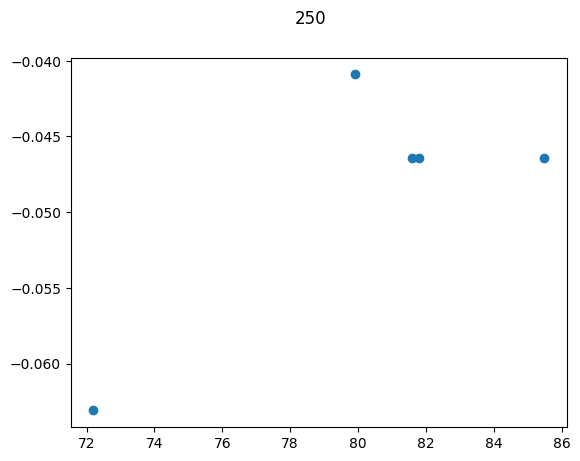

features shape for facebook/deit-tiny-patch16-224: (500,)
labels shape for facebook/deit-tiny-patch16-224: (500,)
results for facebook/deit-tiny-patch16-224 is -0.13695754781079225
features shape for facebook/deit-small-patch16-224: (500,)
labels shape for facebook/deit-small-patch16-224: (500,)
results for facebook/deit-small-patch16-224 is -0.10645907186615465
features shape for facebook/deit-base-patch16-224: (500,)
labels shape for facebook/deit-base-patch16-224: (500,)
results for facebook/deit-base-patch16-224 is -0.09709480941190621
features shape for google/vit-base-patch16-384: (500,)
labels shape for google/vit-base-patch16-384: (500,)
results for google/vit-base-patch16-384 is -0.0870509508104762


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


features shape for microsoft/cvt-13: (500,)
labels shape for microsoft/cvt-13: (500,)
results for microsoft/cvt-13 is -0.1019603907092042
{'facebook/deit-tiny-patch16-224': -0.13695754781079225, 'facebook/deit-small-patch16-224': -0.10645907186615465, 'facebook/deit-base-patch16-224': -0.09709480941190621, 'google/vit-base-patch16-384': -0.0870509508104762, 'microsoft/cvt-13': -0.1019603907092042}


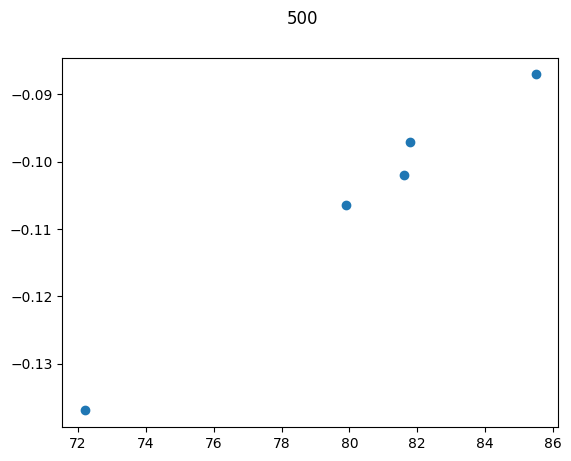

features shape for facebook/deit-tiny-patch16-224: (1000,)
labels shape for facebook/deit-tiny-patch16-224: (1000,)
results for facebook/deit-tiny-patch16-224 is -0.2702765729521843
features shape for facebook/deit-small-patch16-224: (1000,)
labels shape for facebook/deit-small-patch16-224: (1000,)
results for facebook/deit-small-patch16-224 is -0.20243527579168474
features shape for facebook/deit-base-patch16-224: (1000,)
labels shape for facebook/deit-base-patch16-224: (1000,)
results for facebook/deit-base-patch16-224 is -0.17513631317725284
features shape for google/vit-base-patch16-384: (1000,)
labels shape for google/vit-base-patch16-384: (1000,)
results for google/vit-base-patch16-384 is -0.14054817561829752


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


features shape for microsoft/cvt-13: (1000,)
labels shape for microsoft/cvt-13: (1000,)
results for microsoft/cvt-13 is -0.1741861404255224
{'facebook/deit-tiny-patch16-224': -0.2702765729521843, 'facebook/deit-small-patch16-224': -0.20243527579168474, 'facebook/deit-base-patch16-224': -0.17513631317725284, 'google/vit-base-patch16-384': -0.14054817561829752, 'microsoft/cvt-13': -0.1741861404255224}


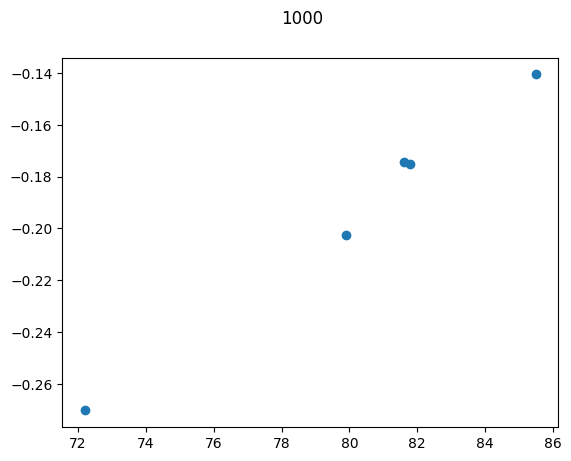

KeyboardInterrupt: 

In [78]:
test_sets = [250, 500, 1000, 2000, 4000]
NCE_results_list = []
for t in test_sets:
    results_list.append(NCE_pipeline(t))

Similar to LogMe this seems to work but should check to see that this isn't just a fluke.

In [15]:
# Experiment with one model to see how the value of LogMe changes with a growing probeset.
random_state = [42, 43, 44]
probe_set_sizes = [
    250,
    500,
    1000,
    1500,
    2000,
    2500,
    3000,
    3500,
    4000,
    4500,
    5000,
    5500,
    6000,
]
NCE_results = {state: [] for state in random_state}
model = "facebook/deit-tiny-patch16-224"

comp_classes = {}
for state in random_state:
    sub_dataset = dataset.shuffle(seed=state)
    comp_classes[state] = extract_classes(model, 6000, sub_dataset)

for size in probe_set_sizes:
    for state in random_state:
        classes = np.concatenate(
            [[feat[0]] for feat in comp_classes[state][:size]], axis=0
        )
        labels = np.concatenate(
            [[feat[1]] for feat in comp_classes[state][:size]], axis=0
        )
        NCE_value = NCE(labels, classes)
        NCE_results[state].append(NCE_value)
        print(f"results for {model} at size {size} is {NCE_value}")

/Users/edable-heath/Documents/ARC-LoCoMoSeT/src/LogME/NCE.py:20: RuntimeWarning: invalid value encountered in divide
  p_target_given_source = (joint / p_z).T  # P(y | z), shape [C_s, C_t]


results for facebook/deit-tiny-patch16-224 at size 250 is -0.07208730677823477
results for facebook/deit-tiny-patch16-224 at size 250 is -0.08736364681731026
results for facebook/deit-tiny-patch16-224 at size 250 is -0.08736364681731026
results for facebook/deit-tiny-patch16-224 at size 500 is -0.17891327878473645
results for facebook/deit-tiny-patch16-224 at size 500 is -0.168815216049793
results for facebook/deit-tiny-patch16-224 at size 500 is -0.1627288853962158
results for facebook/deit-tiny-patch16-224 at size 1000 is -0.2831051050070823
results for facebook/deit-tiny-patch16-224 at size 1000 is -0.28559792012334967
results for facebook/deit-tiny-patch16-224 at size 1000 is -0.2828766478048187
results for facebook/deit-tiny-patch16-224 at size 1500 is -0.3785580607888478
results for facebook/deit-tiny-patch16-224 at size 1500 is -0.36217906525919624
results for facebook/deit-tiny-patch16-224 at size 1500 is -0.35379675218707096
results for facebook/deit-tiny-patch16-224 at size 2

Text(0.5, 0.98, 'Probe set size vs NCE score for facebook/deit-tiny-patch16-224')

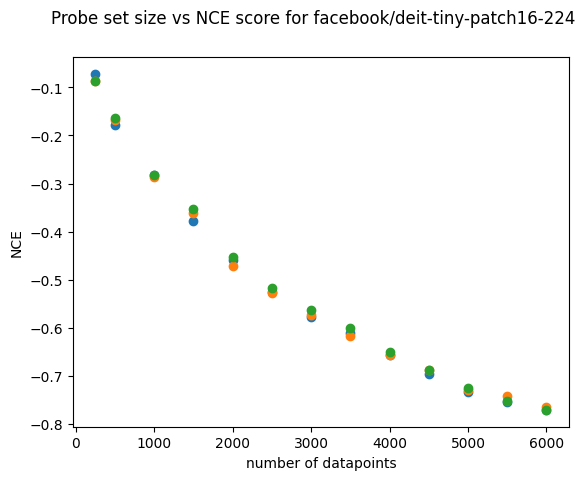

In [18]:
fig, ax = plt.subplots()
for state in random_state:
    ax.scatter(probe_set_sizes, NCE_results[state])
ax.set_xlabel("number of datapoints")
ax.set_ylabel("NCE")
fig.suptitle("Probe set size vs NCE score for facebook/deit-tiny-patch16-224")

### LEEP

In [1]:
from LogME.LEEP import LEEP

In [14]:
def extract_distribution(model_name: str, n_examples: int, dataset: IterableDataset):
    # load model and processor
    model_fn = AutoModelForImageClassification.from_pretrained(model_name)
    processor = AutoImageProcessor.from_pretrained(model_name)

    # preprocess data:
    fn_kwargs = {"processor": processor}
    imgs = dataset.map(
        preprocess,
        remove_columns="image",
        batched=True,
        batch_size=1,
        fn_kwargs=fn_kwargs,
    )
    imgs = imgs.with_format("torch")

    # fxtract features and labels:
    feats = []
    for idx, itm in enumerate(imgs):
        feats.append(
            (
                model_fn(itm["pixel_values"][None, :, :, :]).logits.detach().numpy(),
                itm["label"].detach().numpy(),
            )
        )
        if idx == n_examples - 1:
            break
    return feats

In [15]:
def LEEP_pipeline(n_examples):
    results = {}
    for model in actuals.keys():
        feats = extract_distribution(model, n_examples, dataset)
        classes = np.concatenate([feat[0] for feat in feats], axis=0)
        print(f"features shape for {model}: {classes.shape}")
        labels = np.concatenate([[feat[1]] for feat in feats], axis=0)
        # labels = OneHotEncoder(sparse_output=False).fit_transform(labels.reshape(-1, 1))
        print(f"labels shape for {model}: {labels.shape}")
        leep_score = LEEP(classes, labels)
        if leep_score is np.nan:
            return None
        results[model]
        print(f"results for {model} is {results[model]}")
    print(results)
    plotter(results, str(n_examples))
    return results

In [16]:
test_sets = [3000, 4000, 5000, 6000]
LEEP_results_list = []
for t in test_sets:
    leep_result = LEEP_pipeline(t)
    if leep_result is not None:
        LEEP_results_list.append(LEEP_pipeline(t))
    else:
        print("LEEP returns NaN")
        continue

KeyboardInterrupt: 